In [1]:
import fssa
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit
import matplotlib.colors as colors
from numpy import polyfit, poly1d
from scipy.interpolate import interp1d
import glob
from scipy import signal


In [4]:
#32 sites
file_name = '2023*.npy' 
data = []
data_path = glob.glob(('C:/Users/wangy/Rydberg simulation/rydberg_data/2_1_23/'+file_name))
for path in data_path:
    data.append(np.load(path,allow_pickle=True).tolist())

In [65]:
selected_data = []
for i in range(len(data)):
    if  len(np.array(data[i]['nT'])[:,1])>200 and data[i]['params']['Rabi_ramp_time']==3 and data[i]['params']['quench_time']==0.5 and data[i]['params']['Delta_ini']==-1.5:
      #  len(np.array(data[i]['nT'])[:,1])==223 and
        selected_data.append(data[i])
selected_data = sorted(selected_data, key=lambda selected_data: selected_data['params']['Delta_fin'])   # sort by age
#len(np.array(data[i]['nT'])[:,1]) == 194 and
# for i in range(len(selected_data)):
#     print(i,selected_data[i]['params']['Delta_fin'],len(np.array(selected_data[i]['nT'])[:,1]))
N = []
t = []
detuning = [] 
rabi = [] 
E = [] 
overlap = []
z_list = []
zz_list = []
zg_list = []
zzg_list = []
for i in range(len(selected_data)):
    N.append(selected_data[i]['params']['L'])
    t.append(np.array(selected_data[i]['nT'])[:,1]) # scan time
    detuning.append(np.array(selected_data[i]['nT'])[:,3]) # detuning
    rabi.append(np.array(selected_data[i]['nT'])[:,2]) # Rabi
    E.append(np.array(selected_data[i]['E'])) # energy for the lowest three states
    overlap.append(np.array(selected_data[i]['overlap']))# overlap with fm, afm, ground state, 1st excited state, 2nd excited state
    z_list.append(np.array(selected_data[i]['z'])) # rydberg population  
    zz_list.append(np.array(selected_data[i]['zz']))# correlation of the rydbegrg population
    zg_list.append(np.array(selected_data[i]['zg']))# rydberg population for the ground state
    zzg_list.append(np.array(selected_data[i]['zzg']))# correlation of the rydberg population for the ground state
    print('i',i)
    print('U',selected_data[i]['params']['Delta_fin'])
    print(zzg_list[i].shape)
print(selected_data[i]['params'])

i 0
U 1.35
(273, 24, 24)
i 1
U 1.45
(273, 24, 24)
i 2
U 1.53
(273, 24, 24)
i 3
U 1.62
(273, 24, 24)
i 4
U 1.68
(273, 24, 24)
{'dirc': '/n/home03/bye/tenpy_squeezing/workfolder_yu/output_cluster/', 'L': 24, 'Omega': 1.5, 'U': 8.0, 'chi': 128, 'N_steps': 1, 'Rabi_ramp_time': 3.0, 'Rabi_ramp_dt': 0.1, 'quench_time': 0.5, 'quench_dt': 0.01, 'Delta_ini': -1.5, 'Delta_fin': 1.68, 'dt': 0.052, 'evolve_time': 10.0}


In [66]:
sigma_1_list = []
sigma_2_list = []
x_list = []
for i in range(len(N)):
    sigma1 = [] # single body sigma field
    sigma2 = [] # correlation of sigma field
    # do something
    sign = np.ones(N[i])
    sign[0::2]=-1
    x_temp = np.arange(N[i])
    x_list.append(x_temp)
    for t_index in range(len(selected_data[i]['zz'])):
        n_temp = np.array(selected_data[i]['z'])[t_index] # rydberg population at time t
        n_temp_mean = np.mean(n_temp)
        nn_temp = np.array(selected_data[i]['zz'])[t_index]
        sigma_temp = (n_temp[:]-n_temp_mean)*sign
        sigma1.append(sigma_temp)
        
        for x in x_temp:
            temp_g = (-1)**x *(nn_temp[0,x]-n_temp_mean*n_temp[0]-n_temp_mean*n_temp[x]+n_temp_mean**2)
            sigma2.append(temp_g)
    sigma2 = np.array(sigma2)
    sigma2 = sigma2.reshape(len(selected_data[i]['zg']),N[i])
    sigma_1_list.append(sigma1)   
    sigma_2_list.append(sigma2)

Text(0.5, 0, 'MHz')

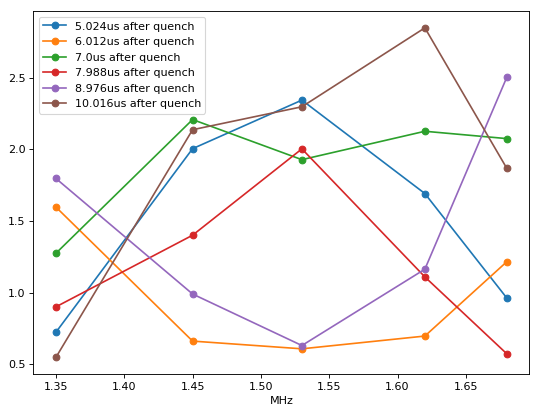

In [87]:
t_list = [8,9,10,11,12,13]
plt.figure(figsize=(8, 6), dpi=80)

for i_t in range(len(t_list)):
    Delta_fin_list = []
    order_parameter = []
    for i_n,i in enumerate(range(len(N))):
        Delta_fin_list.append(selected_data[i]['params']['Delta_fin'])
        t_id = np.argmin(abs(t[i]-t_list[i_t]))
        temp = sigma_2_list[i]
        order_parameter.append(np.sum(temp,axis=1)[t_id])
    plt.plot(Delta_fin_list,order_parameter,marker = 'o',label = str(round(t[i][t_id]-3,3))+'us after quench')
plt.legend()
plt.xlabel('MHz')

Text(0.5, 1.0, 'order parameter dynamics as a function of quench levels')

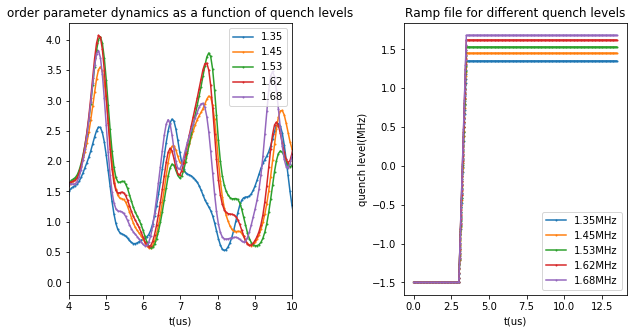

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
for i in range(len(N)):
    label0 = str(round(selected_data[i]['params']['Delta_fin'],3))+'MHz'
    ax[1].plot(t[i],detuning[i],marker='o',markersize = 1,label = label0 )
order_parameter = []
for i_n,i in enumerate(range(len(N))):
    temp = sigma_2_list[i]
    order_parameter.append(np.sum(temp,axis=1)[:])
j = np.arange(len(N))
for j_n in j:
    ax[0].plot(t[j_n],order_parameter[j_n],marker = 'o',label = Delta_fin_list[j_n],markersize = 1)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([4,10])

ax[0].set_xlabel('t(us)')
ax[1].set_xlabel('t(us)')
ax[1].set_ylabel('quench level(MHz)')
ax[1].set_title('Ramp file for different quench levels')
ax[0].set_title('order parameter dynamics as a function of quench levels')

In [57]:
for i in range(len(N)):
    print(Delta_fin_list[i],np.mean(order_parameter[i][40:]))

1.35 1.1994469588062686
1.45 1.3629615777322792
1.45 1.4301851960685261
1.53 1.6087123932307137
1.6 1.6255626189326768
1.62 1.612585154421463
1.68 1.5008023782984552
1.7 1.4457726858697768


In [69]:
for i in range(len(N)):
    print(Delta_fin_list[i],np.mean(order_parameter[i][40:]))

1.35 1.2445979917689485
1.45 1.5428795600958654
1.53 1.6463085709940257
1.62 1.6405707245329109
1.68 1.5277141913524583


In [64]:
for i in range(len(N)):
    print(Delta_fin_list[i],np.mean(order_parameter[i][40:]))

1.35 1.2962617794005327
1.45 1.6093892761731006
1.53 1.7139421102798762
1.6 1.7163438207922745
1.62 1.7047014732955155
1.68 1.5811781303206573
1.7 1.5210798302283155


In [77]:
temp = Delta_fin_list[i],np.mean(order_parameter[:,40:])

TypeError: list indices must be integers or slices, not tuple

[]